In [2]:
%matplotlib inline
import os
import sys

import pandas as pd
import numpy as np

BASE_PATH = os.path.dirname(os.getcwd())
sys.path.append(BASE_PATH)

import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
from matplotlib import rc
rc('font', family = 'AppleGothic')

In [4]:
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

이미지 배열을 x_train에 추가

In [32]:
import matplotlib.image as img
x_train = []
x_test = []
for image, label in zip(train_df['img_path'], train_df['text']):
    image_path = os.path.join('../data/', image[2:])
    i = cv2.imread(image_path)
    i_arr = np.array(i, 'uint8')
    x_train.append(i_arr)

In [33]:
# train image 크기 출력
print(len(x_train))

12159


In [7]:
for image in test_df['img_path']:
    image_path = os.path.join('../data/', image[2:])
    image_path = os.path.join('../data/',image[2:])
    i = cv2.imread(image_path)
    x_test.append(i)
    
print(len(x_test))

3669


In [8]:
len(train_df['text'])

12159

### SRN 모델 구성

In [10]:
from models.layers import ResidualConvFeatureExtractor
from tensorflow.keras.layers import Input

K.clear_session()

height = 36

n_conv = 16 # the number of Convolution filter
n_state = 256 # the number of GRU units
n_embed = 16 # the size of embedding vector
n_clf = 256 # the number of units in classifier Dense layer

# Image Encoder
inputs = Input(shape=(height, None, 1),name='images')
conv_maps = ResidualConvFeatureExtractor(n_conv,
                                         name='feature_extractor')(inputs)

Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-10-02 17:29:13.861841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-02 17:29:13.863238: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Map2Sequence 구성

In [11]:
from models.layers import Map2Sequence

feature_seqs = Map2Sequence(name='map_to_sequence')(conv_maps)

### Embedding Layer 구성

In [12]:

from models.layers import JamoEmbedding, TeacherForcing

# 교사 강제 학습
y_true = Input(shape=(None,), dtype=tf.int32, name='output_sequences')
decoder_inputs = TeacherForcing()(y_true)

jamo_embedding_layer = JamoEmbedding(n_embed)
jamo_embedding = jamo_embedding_layer(decoder_inputs)

### Text Decoder Layer 구성

In [13]:
from tensorflow.keras.layers import GRU

# Text Decoder
gru_layer = GRU(n_state, 
                name='decoder_gru', 
                return_sequences=True)
states_decoder = gru_layer(jamo_embedding)

### Attention Layer 구성

In [14]:
from models.layers import DotAttention
from tensorflow.keras.layers import Concatenate

dotattend = DotAttention(n_state=n_state)
context, attention = dotattend([feature_seqs, states_decoder])

concat_state = Concatenate(axis=-1, name='concat_output')(
    [context, states_decoder])

### Attention Layer 구성

In [15]:
from models.layers import JamoClassifier

# Classifier Layer
jamo_clf = JamoClassifier(n_clf, name='output_seqs')
y_pred = jamo_clf(concat_state)

### Character Classification Layer 구성

In [16]:
from models.layers import JamoClassifier

jamo_clf = JamoClassifier(n_clf, name='output_seqs')
y_pred = jamo_clf(concat_state)

### Loss Layer 구성

In [17]:
from models.losses import JamoCategoricalCrossEntropy

loss = JamoCategoricalCrossEntropy(blank_value=-1.)([y_true, y_pred])

### 학습 모델 구성

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# For training
trainer = Model([inputs, y_true],[loss], name='trainer')
trainer.add_loss(loss)

# Model 컴파일하기
trainer.compile(Adam(lr=1e-2))

/Users/suhye/miniforge3/envs/newenv/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


### 모델 학습하기

In [19]:
from tensorflow.keras.utils import Sequence

class JAMOSeq2SeqGenerator(Sequence):
    "초성 중성 종성 각각 나누어서 Return"

    def __init__(self, dataset, batch_size=32,
                 blank_value=-1, shuffle=False):
        """
        Initialization

        param
        :param dataset : instance of class 'OCRDataset'
        :param batch_size : the number of batch
        :param blank_value : the value of `blank` label
        :param shuffle : whether shuffle dataset or not
        """
        if isinstance(dataset, dict):
            dataset = OCRDataset(**dataset)
        self.dataset = dataset
        self.batch_size = batch_size
        self.blank_value = blank_value
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        "Denotes the number of batches per epoch"
        return len(self.dataset) // self.batch_size

    def __getitem__(self, index):
        "Generator one batch of dataset"
        images, texts = self.dataset[self.batch_size * index:
                                     self.batch_size * (index + 1)]

        max_len = max([len(text) for text in texts]) + 1
        unicode_arr = np.ones((self.batch_size, max_len), dtype=np.int) * -1
        for idx, text in enumerate(texts):
            unicode_arr[idx, :len(text)] = np.array([ord(char) for char in text])
            unicode_arr[idx, len(text)] = ord('\n')
        decode_inputs = np.roll(unicode_arr, 1, axis=1)
        decode_inputs[:, 0] = ord('\n')
        decode_inputs = decode_inputs.astype(np.int32)

        X = {
            "images": images,
            "output_sequences": unicode_arr
        }
        return (X, )

    #def on_epoch_end(self):
        "Updates indexes after each epoch"
        if self.shuffle:
            self.dataset.shuffle()

In [20]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from multiprocessing import cpu_count

callbacks =[]
rlrop = ReduceLROnPlateau(
    factor=0.5, patience=2, 
    min_lr=1e-6, verbose=1,cooldown=5)
callbacks.append(rlrop)

epochs = 50

train_gen = JAMOSeq2SeqGenerator(x_train, batch_size=128)
test_gen = JAMOSeq2SeqGenerator(x_test, batch_size=128)


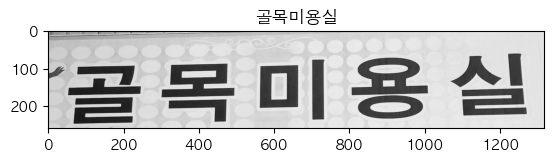

In [22]:
image = x_train[0]
plt.title(train_df['text'][0])
plt.imshow(image[:,:,0], cmap='gray')
plt.show()

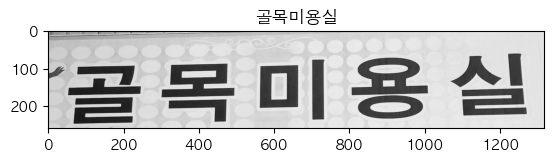

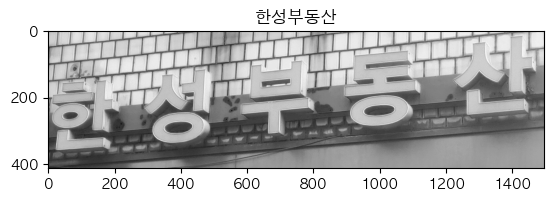

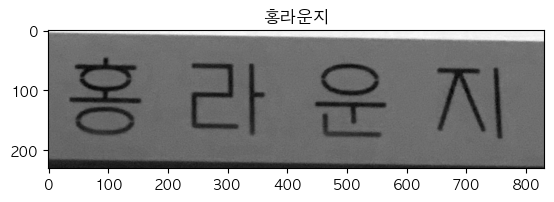

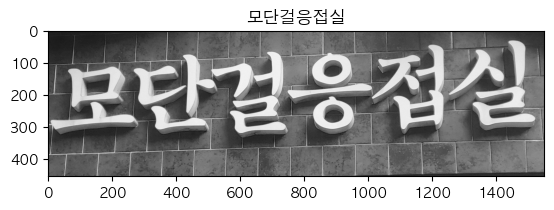

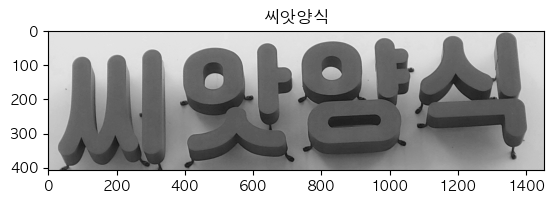

In [23]:
for image, label in zip(x_train[:5], train_df['text'][:5]):
    plt.title(label)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.show()

In [25]:
train_gen = JAMOSeq2SeqGenerator(dataset=(x_train, train_df['text']), batch_size=4)
train_gen

#X = train_gen[0][0]
#for i in range(3):
    #image = x['image'][i:,:,0]
    #plt.imshow(image, cmap='gray')
    #plt.show()

In [34]:
train_gen = ({'images':x_train, 
             'output_sequences':train_df['text']},)


In [35]:
hist = trainer.fit_generator(train_gen, steps_per_epoch=1000,
                             epochs=epochs, callbacks=callbacks,
                             use_multiprocessing=True,
                             )

/var/folders/7n/pm50m3212tq_hg29f8q2fdh00000gn/T/ipykernel_15264/1462447305.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = trainer.fit_generator(train_gen, steps_per_epoch=1000,
